In [3]:
%%bigquery --use_rest_api train_data
select * from `research_articles.train_split`

Downloading: 100%|██████████| 16828/16828 [00:04<00:00, 3524.70rows/s]


In [4]:
%%bigquery --use_rest_api val_data
select * from `research_articles.val_split`

Downloading: 100%|██████████| 4144/4144 [00:00<00:00, 4230.65rows/s]


In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas
from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,auc,f1_score,accuracy_score
import numpy as np
import tqdm 
import matplotlib.pyplot as plt


In [2]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")


2023-06-16 07:04:41.192891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 07:04:41.205571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 07:04:41.207168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 07:04:41.209480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
labels = ['Computer_Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative_Biology', 'Quantitative_Finance']


In [8]:
def get_df_with_prediction(data, text_colums):
    df = data.copy()
    arr_pred = []
    it = 1
    for id in tqdm.tqdm(df.index):
        sequence = " ".join([df[col][id] for col in text_colums])
        input_embedding = use_model([sequence])[0]
        label_embeddings = use_model(labels)
        scores = tf.reduce_sum(input_embedding * label_embeddings, axis=1)
        arr_pred.append(scores.numpy())
    df['pred'] = arr_pred
    return df

In [13]:
val_data_with_pred = get_df_with_prediction(val_data, ["TITLE", "ABSTRACT"])

100%|██████████| 4144/4144 [03:46<00:00, 18.28it/s]


In [12]:
val_data_with_pred["pred"][0]

array([-0.0468403 ,  0.00268917, -0.01372026,  0.01183269, -0.0867845 ,
        0.00597687], dtype=float32)

In [20]:
def metrics(topic, y_true, y_pred, y_prob=None, draw=True):        
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    metric_map = {
        'topic': topic,
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'accuracy': acc,        
        'true negative':tn, 
        'false positive': fp,
        'false negative': fn,
        'true positive': tp,

    }
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auc_score = auc(fpr, tpr)
        metric_map['auc'] = auc_score
        if draw:
            plt.title(f'{topic} ROC')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_score)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()        
    return metric_map
    

def evaluate(df, threshold=0.0):
    result = {}
    for topic in labels:
        result[topic] = {"y_true":[], "y_pred":[], "y_prob":[]}
    for id in df.index:
        pred = df["pred"][id]
        for i,topic in enumerate(labels):
            result[topic]["y_true"].append(df[topic][id])
            result[topic]["y_prob"].append(pred[i])
            result[topic]["y_pred"].append(pred[i]>threshold)                
                
                
    eval_result = []
    for topic in result.keys():
        eval_result.append(
            metrics(
                topic,
                result[topic]["y_true"], 
                result[topic]["y_pred"], 
                result[topic]["y_prob"]
            )
        )
    eval_df = pandas.DataFrame(eval_result)
    return eval_df



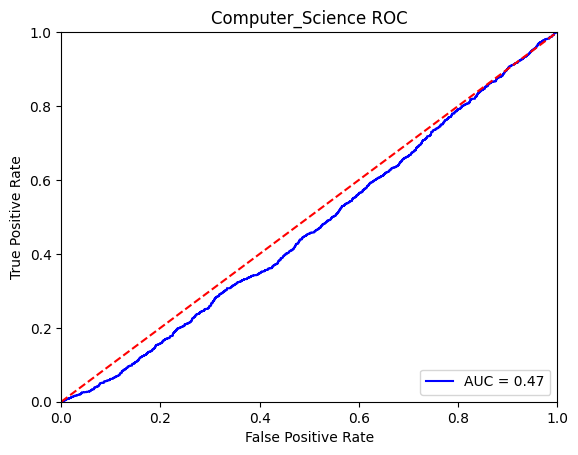

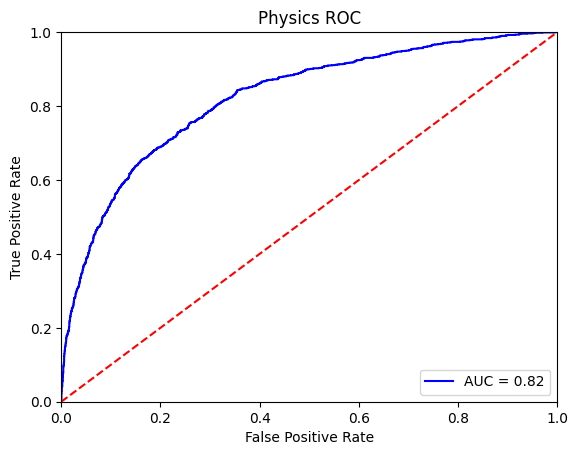

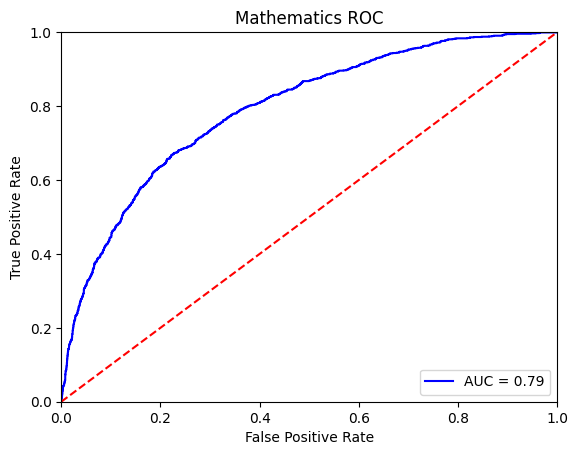

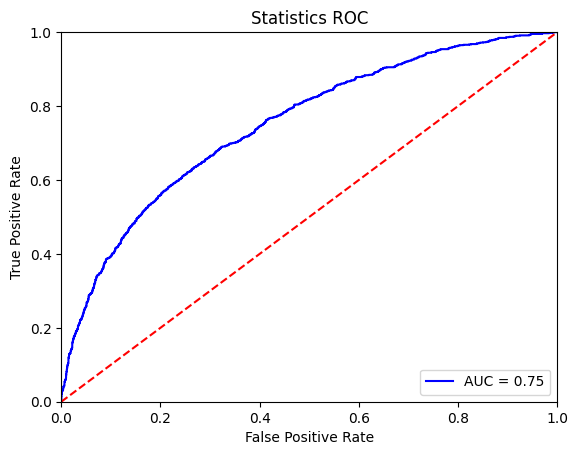

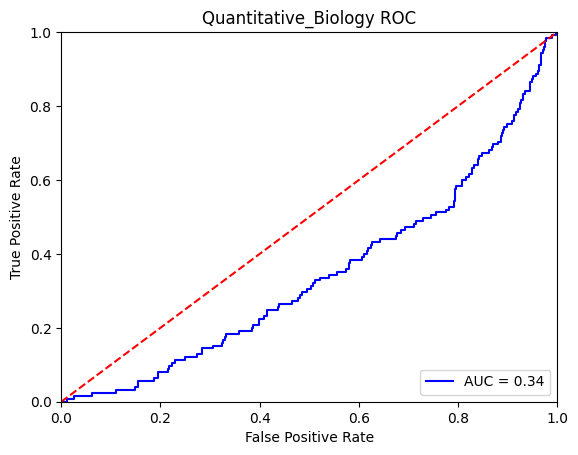

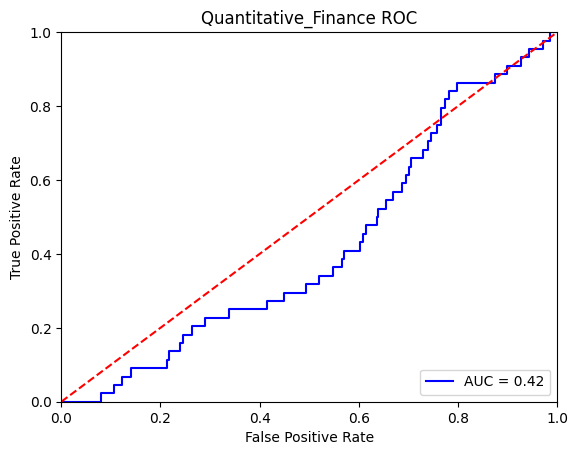

,topic,precision,recall,f1_score,accuracy,true negative,false positive,false negative,true positive,auc
0,Computer_Science,0.396842,0.651738,0.493310,0.451737,766,1681,591,1106,0.469991
1,Physics,0.595328,0.671769,0.631243,0.777268,2431,537,386,790,0.822746
2,Mathematics,0.401826,0.855124,0.546738,0.612693,1571,1441,164,968,0.791695
3,Statistics,0.420335,0.664055,0.514806,0.691602,2188,935,343,678,0.749032
4,Quantitative_Biology,0.017479,0.264000,0.032787,0.530164,2164,1855,92,33,0.344235
5,Quantitative_Finance,0.007736,0.250000,0.015007,0.651544,2689,1411,33,11,0.420698


In [23]:
evaluate(val_data_with_pred)

## Customized Label

In [24]:
topic_mapping1 = {
    "Computer Science" : "Computer_Science",
    "Physics": "Physics",
    "Mathematics": "Mathematics",
    "Statistics": "Statistics",
    "Biology": "Quantitative_Biology",
    "Finance": "Quantitative_Finance",
}

In [25]:
def get_df_with_prediction(data, text_colums, topic_mapping):
    labels = [k for k in topic_mapping.keys()]
    df = data.copy()
    arr_pred = []
    it = 1
    for id in tqdm.tqdm(df.index):
        sequence = " ".join([df[col][id] for col in text_colums])
        input_embedding = use_model([sequence])[0]
        label_embeddings = use_model(labels)
        scores = tf.reduce_sum(input_embedding * label_embeddings, axis=1)
        arr_pred.append(scores.numpy())
    df['pred'] = arr_pred
    return df

In [27]:
val_data_with_pred1 = get_df_with_prediction(val_data, ["TITLE", "ABSTRACT"], topic_mapping1)

100%|██████████| 4144/4144 [03:38<00:00, 18.96it/s]


In [44]:
def evaluate(df, topic_mapping, threshold=0.0):
    labels = [k for k in topic_mapping.keys()]
    result = {}
    for topic in labels:
        result[topic] = {"y_true":[], "y_pred":[], "y_prob":[]}
    for id in df.index:
        pred = df["pred"][id]
        for i,topic in enumerate(labels):
            result[topic]["y_true"].append(df[topic_mapping[topic]][id])
            result[topic]["y_prob"].append(pred[i])
            result[topic]["y_pred"].append(pred[i]>threshold)                
                
                
    eval_result = []
    for topic in result.keys():
        eval_result.append(
            metrics(
                 f"{topic_mapping[topic]}",# - \"{topic}\"",
                result[topic]["y_true"], 
                result[topic]["y_pred"], 
                result[topic]["y_prob"]
            )
        )
    eval_df = pandas.DataFrame(eval_result)
    return eval_df

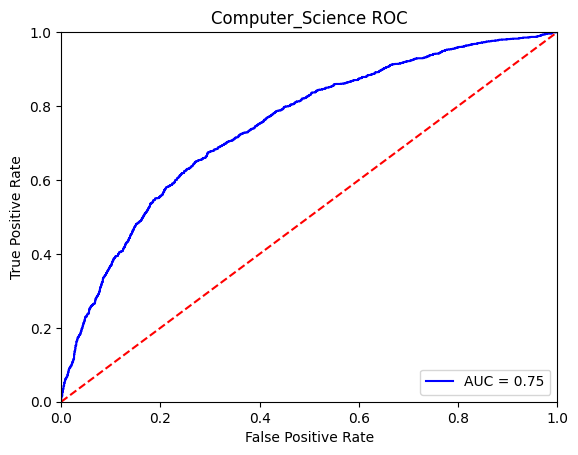

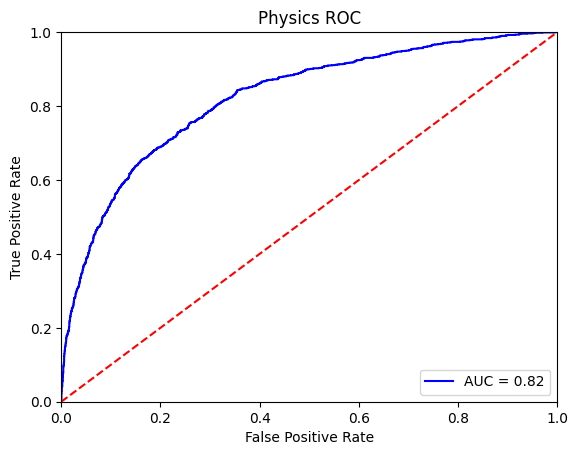

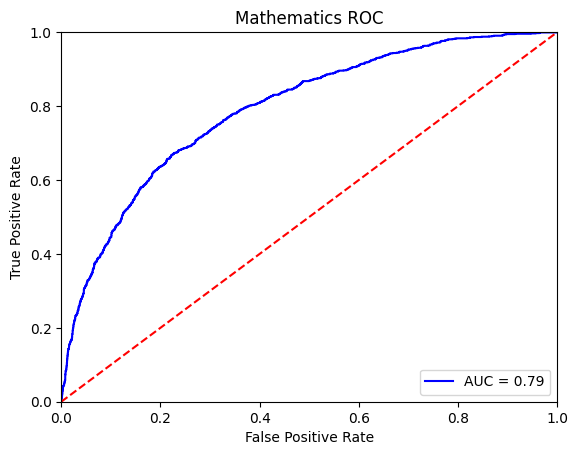

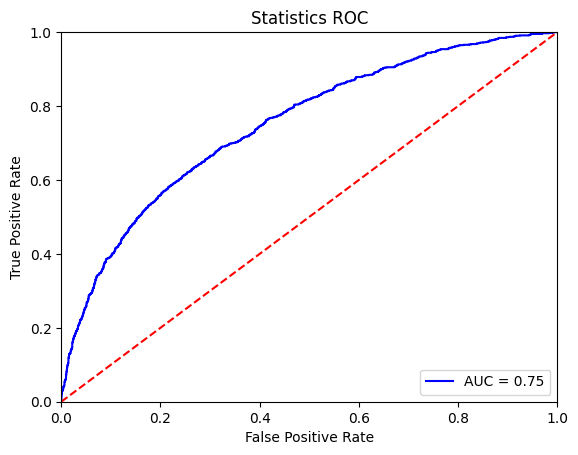

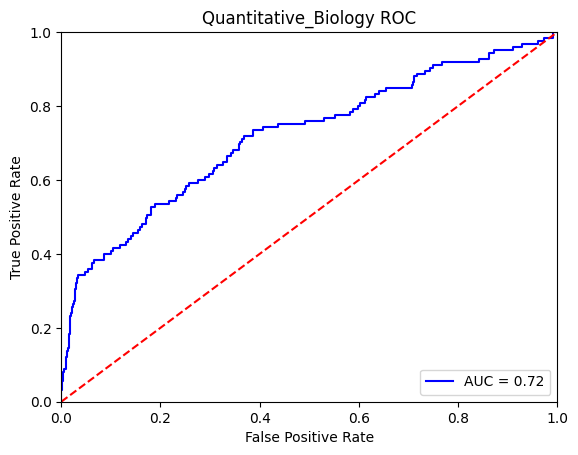

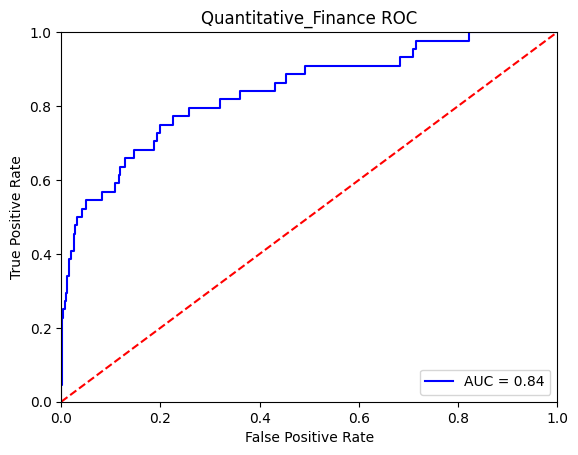

,topic,precision,recall,auc
0,Computer_Science,0.606635,0.678845,0.746261
1,Physics,0.595328,0.671769,0.822746
2,Mathematics,0.401826,0.855124,0.791695
3,Statistics,0.420335,0.664055,0.749031
4,Quantitative_Biology,0.154605,0.376000,0.718744
5,Quantitative_Finance,0.046729,0.681818,0.839690


In [53]:
evaluate(val_data_with_pred1, topic_mapping1)[["topic", "precision", "recall", "auc"]]

In [38]:
topic_mapping2 = {
    "The paper is about Computer Science" : "Computer_Science",
    "The paper is about Physics": "Physics",
    "The paper is about Mathematics": "Mathematics",
    "The paper is about Statistics": "Statistics",
    "The paper is about Biology": "Quantitative_Biology",
    "The paper is about Finance": "Quantitative_Finance",
}

In [39]:
val_data_with_pred2 = get_df_with_prediction(val_data, ["TITLE", "ABSTRACT"], topic_mapping2)

100%|██████████| 4144/4144 [03:39<00:00, 18.88it/s]


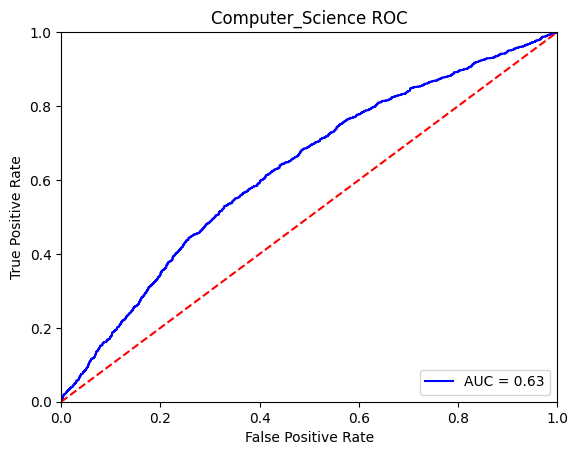

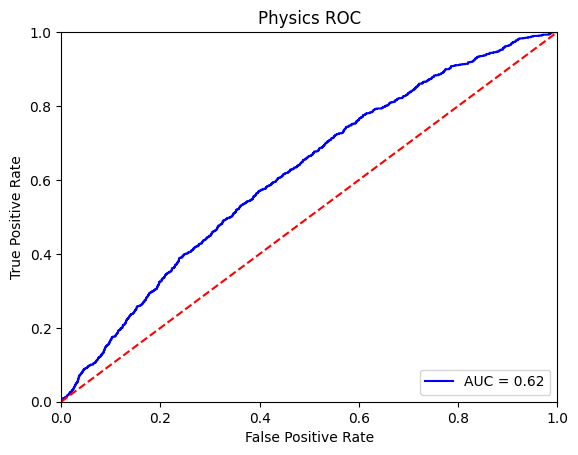

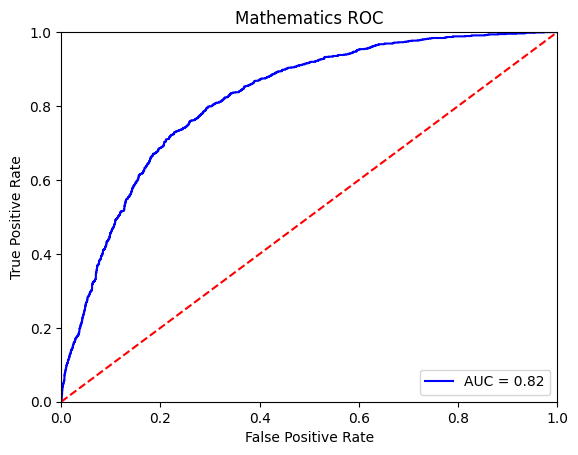

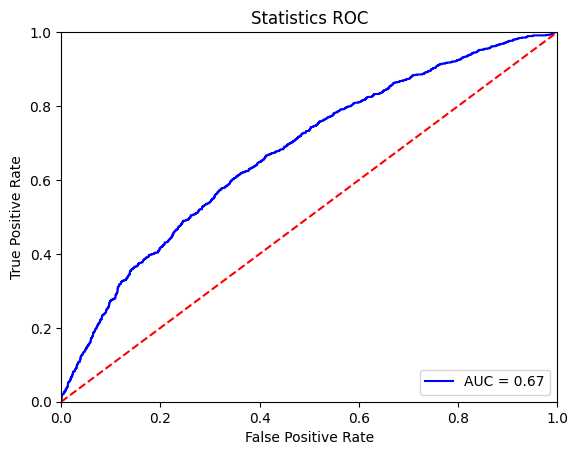

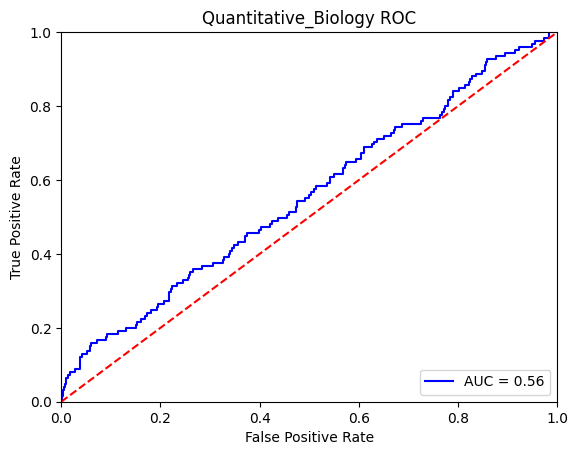

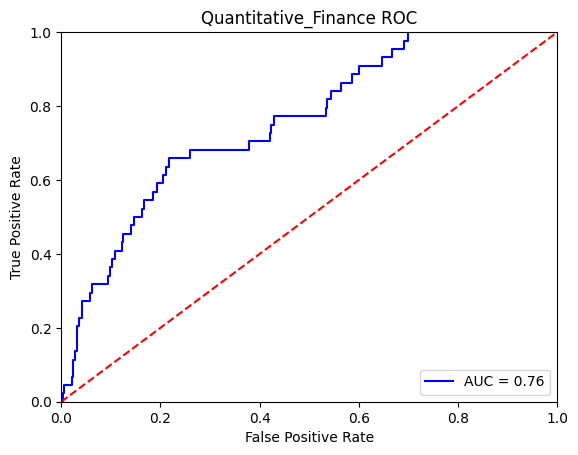

,topic,precision,recall,auc
0,Computer_Science,0.453744,0.849735,0.627406
1,Physics,0.334427,0.779762,0.616024
2,Mathematics,0.339368,0.977032,0.819254
3,Statistics,0.340099,0.672870,0.673702
4,Quantitative_Biology,0.035840,0.408000,0.555760
5,Quantitative_Finance,0.019448,0.704545,0.756818


In [51]:
evaluate(val_data_with_pred2, topic_mapping2)[["topic", "precision", "recall", "auc"]]

In [47]:
topic_mapping0 = {
    "Computer Science" : "Computer_Science",
    "Physics": "Physics",
    "Mathematics": "Mathematics",
    "Statistics": "Statistics",
    "Quantitative Biology": "Quantitative_Biology",
    "Quantitative Finance": "Quantitative_Finance",
}

In [48]:
val_data_with_pred0 = get_df_with_prediction(val_data, ["TITLE", "ABSTRACT"], topic_mapping0)

100%|██████████| 4144/4144 [03:37<00:00, 19.04it/s]


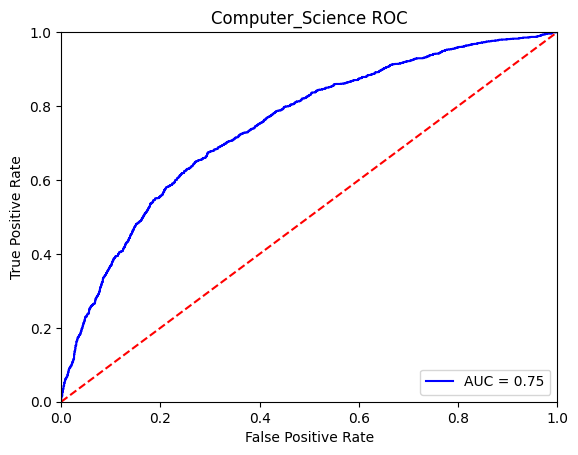

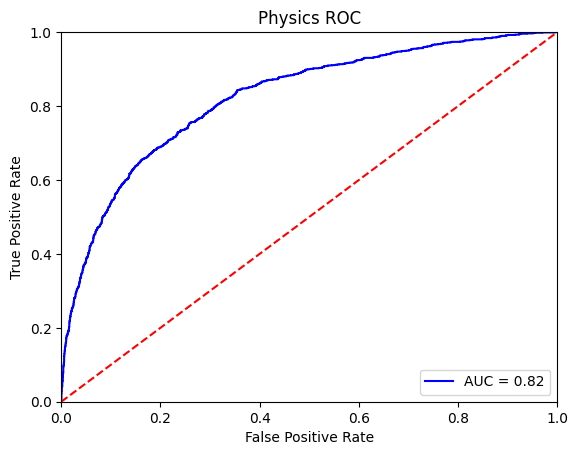

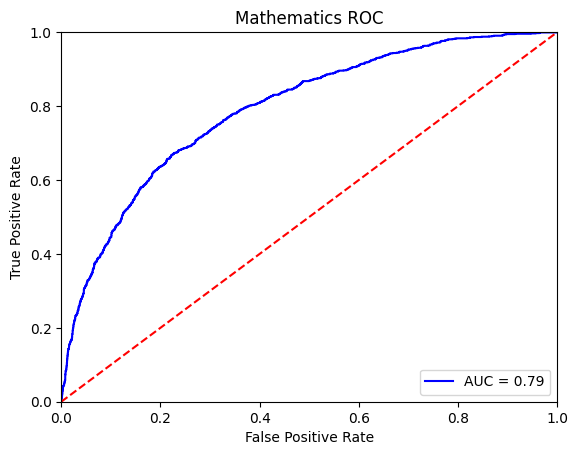

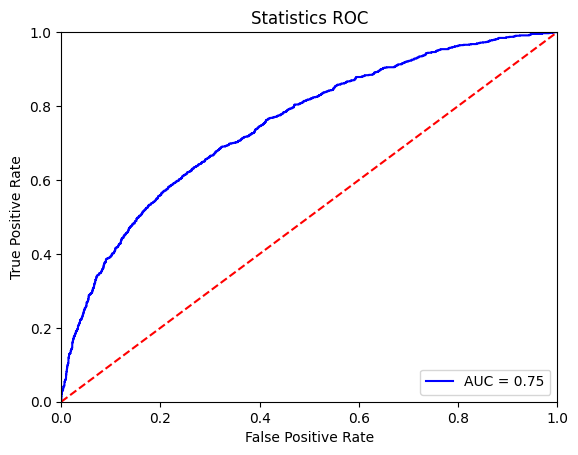

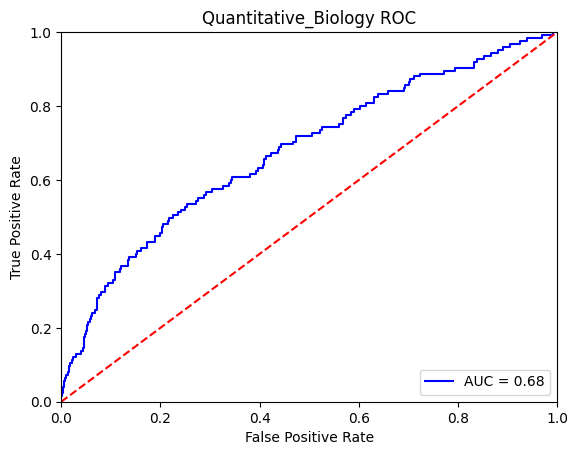

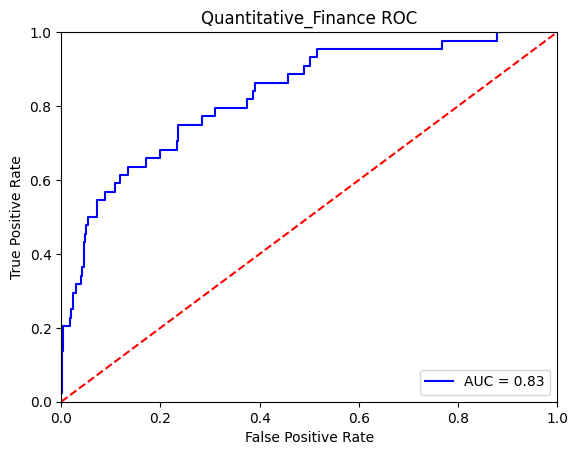

,topic,precision,recall,auc
0,Computer_Science,0.606635,0.678845,0.746261
1,Physics,0.595328,0.671769,0.822746
2,Mathematics,0.401826,0.855124,0.791695
3,Statistics,0.420335,0.664055,0.749032
4,Quantitative_Biology,0.040016,0.792000,0.676915
5,Quantitative_Finance,0.015730,0.954545,0.829013


In [52]:
evaluate(val_data_with_pred0, topic_mapping0)[["topic", "precision", "recall", "auc"]]